In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Pipeline: chaininig estimator
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Data imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

# Feature Selection/Dimensionality Reduction

# Feature normalisation
from sklearn.preprocessing import StandardScaler

# Train test split
from sklearn.model_selection import train_test_split

# Model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Load dataset, drop row and ID column

In [2]:
all_df = pd.read_excel("./Dataset/trainDataset.xls", sheet_name="Sheet1")
all_df = all_df.drop([218, 253, 285])
dataset_ID = all_df['ID']
all_df.drop('ID', axis=1, inplace=True)

## Data Imputation

In [3]:
missing_values_index = np.where(all_df.isin([999]) == True)
missing_values_index = np.array(missing_values_index)

new_df = all_df.replace(999, np.NaN)
column_names = new_df.columns

k_imp = KNNImputer()
k_imputed_array = k_imp.fit_transform(new_df)

multivariate_imp = IterativeImputer(random_state=42)
multi_imputed_array = multivariate_imp.fit_transform(new_df)

# loop through all the missing values rows and columns and impute the data with round up function
for i in range(len(missing_values_index[0])):
    row = missing_values_index[0][i]
    col = missing_values_index[1][i]
    k_imputed_array[row][col] = np.round(k_imputed_array[row][col])
    multi_imputed_array[row][col] = np.round(multi_imputed_array[row][col])
    print(k_imputed_array[row][col], multi_imputed_array[row][col])

# convert to dataFrame
k_imputed_df = pd.DataFrame(k_imputed_array, columns=column_names)
multi_imputed_df = pd.DataFrame(multi_imputed_array, columns=column_names)

# write imputed dataframe into excel sheet
k_imputed_df.to_excel('./knnImputedDataset.xlsx', sheet_name='Sheet 1', index=False)
multi_imputed_df.to_excel('./multivariateImputedDataset.xlsx', sheet_name='Sheet 1', index=False)

0.0 0.0
3.0 3.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0


### Upsampling the shrinked dataset

In [11]:
# not_shrink = multi_imputed_df[multi_imputed_df["pCR (outcome)"] == 0]
# shrinked  = multi_imputed_df[multi_imputed_df["pCR (outcome)"] == 1]

In [12]:
# from sklearn.utils import resample

# shrinked = resample(shrinked,
#              replace=True,
#              n_samples=len(not_shrink),
#              random_state=42)

# multi_imputed_df = pd.concat([shrinked, not_shrink])

#### Assign independent and dependent variable

In [4]:
# Split the features and target values
X = multi_imputed_df.iloc[:, 2:]

# Target values: pCR (outcome)
classification_target = multi_imputed_df.iloc[:, :1]

#### Data Normalisation

In [5]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

## Feature Selection

In [6]:
import shap

from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

In [7]:
# Figure size settings
plt.rcParams.update({'figure.figsize': (100.0, 100.0)})
plt.rcParams.update({'font.size': 50})

### Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(Xs, 
                                                    classification_target,
                                                    stratify=classification_target,
                                                    test_size=0.3, 
                                                    random_state=42)

In [9]:
from sklearn.model_selection import GridSearchCV

rf_pre = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': np.arange(200, 500, 100).tolist(),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7],
    'criterion' :['gini', 'entropy']
}      
                           
CV_rfc = GridSearchCV(estimator=rf_pre, param_grid=param_grid, cv= 5, verbose=3)
CV_rfc.fit(Xs, classification_target)
print(CV_rfc.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=200;, score=0.762 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=200;, score=0.762 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=200;, score=0.759 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=200;, score=0.759 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=200;, score=0.759 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=300;, score=0.762 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=300;, score=0.762 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=300;, score=0.759 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=3, max_feat

#### Random Forest Classification (Feature Selection)

In [10]:
# {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 400}
# {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
# {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 400}
# {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 400}
rf = RandomForestClassifier(class_weight="balanced", random_state=42, criterion='gini', max_depth=7, max_features='auto',n_estimators=400)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=400,
                       random_state=42)

Text(0.5, 0, 'Random Forest Feature Importance')

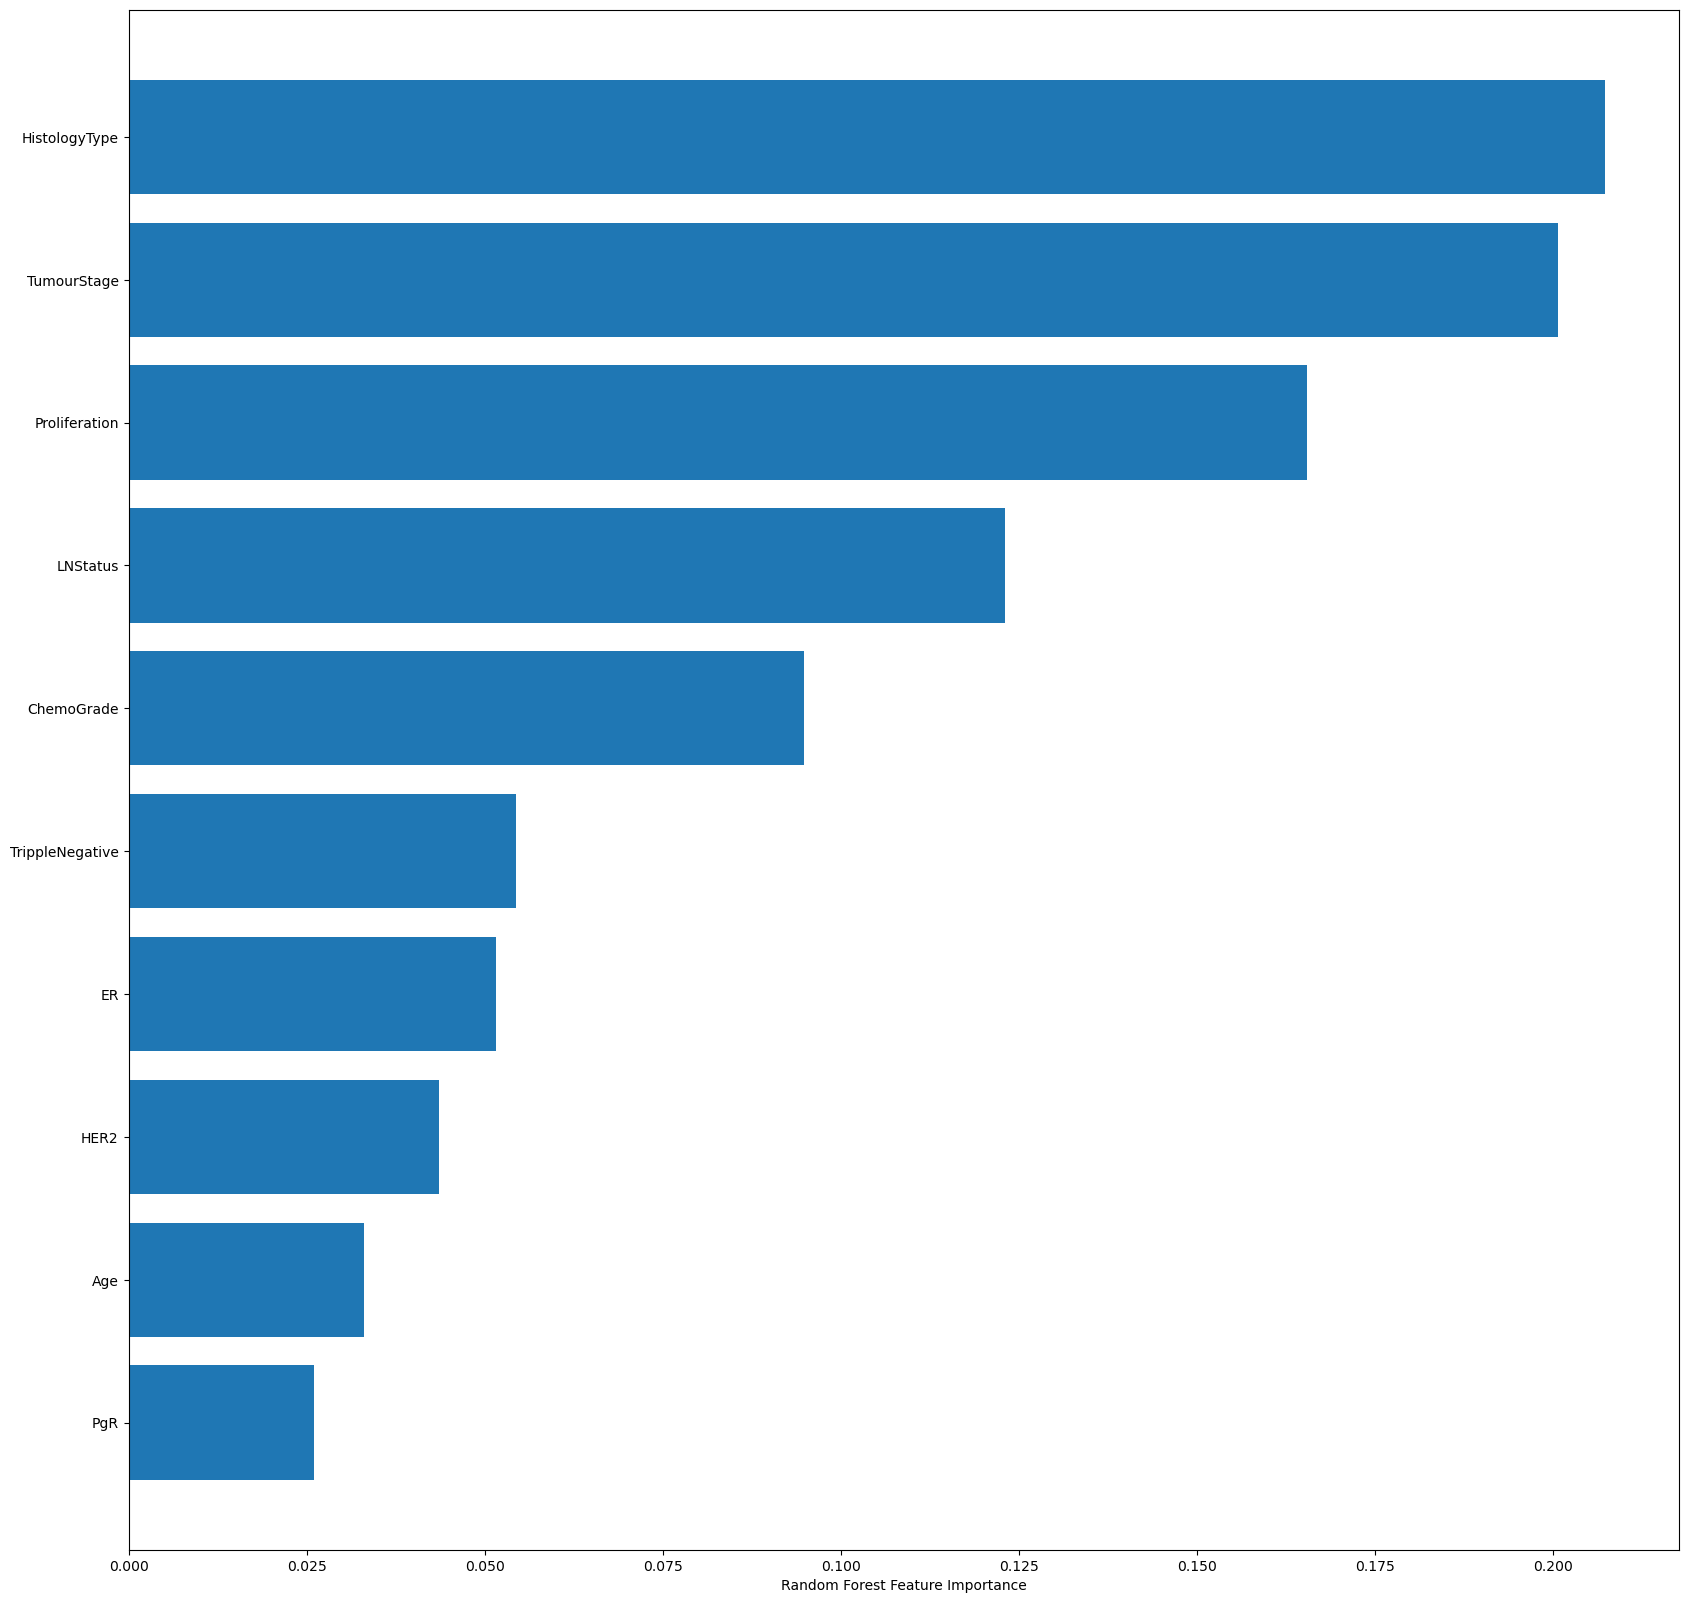

In [33]:
# Sort the features
sorted_idx = rf.feature_importances_.argsort()
# Choose number of features to be displayed
num_select_features = 20
sorted_idx = sorted_idx[:num_select_features]

# Display the plot
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Permutation Based Feature Importance

In [34]:
# perm_importance = permutation_importance(rf, X_test, y_test, random_state=42)
# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")

#### Assigned selected feature

In [35]:
# sorted_idx = sorted_idx[:num_select_features]

# column_header = list(X.columns)
# X_train = pd.DataFrame(X_train, columns = column_header)
# X_test = pd.DataFrame(X_test, columns = column_header)

# column_header = list(X.columns[sorted_idx])
# # X_train = X_train.iloc[:, column_header]
# # X_test = X_test.iloc[:, column_header]
# X_train = X_train[column_header]
# X_test = X_test[column_header]


In [36]:
# Assigned selected feature
X_train = X_train[:, sorted_idx]
X_test = X_test[:, sorted_idx]

# Selected feature's Header name
column_header = X.columns[sorted_idx]

#### Split training and testing data

In [37]:
# X_train, X_test, y_train, y_test = train_test_split(Xs_selected, 
#                                                     classification_target,
#                                                     stratify=classification_target,
#                                                     test_size=0.3, 
#                                                     random_state=42)

## Pipeline

In [38]:
from sklearn.model_selection import GridSearchCV 

# SVC
svc_clf = SVC(random_state=42)
svc_pipeline = make_pipeline(svc_clf)


f_svc_search = GridSearchCV(svc_pipeline,
                            param_grid={'svc__C': np.arange(0, 10, 1).tolist(),
                                       'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                       'svc__degree': np.arange(3, 5, 1).tolist(),
                                       'svc__gamma': ['auto','scale']},
                            scoring='accuracy',
                           verbose=3)


# Logistic Regression
lr_clf = LogisticRegression(random_state=42)
lr_pipeline = make_pipeline(lr_clf)


f_lr_search = GridSearchCV(lr_pipeline,
                            param_grid={'logisticregression__C': np.arange(0, 10, 1).tolist()},
                            scoring='accuracy')

# Random Forest Classification
rf_clf = RandomForestClassifier(random_state=42)
rf_pipeline = make_pipeline(rf_clf)

f_rf_search = GridSearchCV(rf_clf,
                            param_grid={'n_estimators': np.arange(50,200,15).tolist(),
                                        'max_features': ['auto', 'sqrt', 'log2'],
                                        'max_depth' : [3,5,7,9],
                                        'criterion' :['gini']},
                            scoring='accuracy',
                           verbose=3)

In [39]:
# SVC
# f_svc_search.fit(X_train, y_train)
# print("Best parameter for SVC ", f_svc_search.best_params_)
# print("Accuracy: ", f_svc_search.best_score_, "\n")

# Logistic Regression
# f_lr_search.fit(X_train, y_train)
# print("Best parameter for LR ", f_lr_search.best_params_)
# print("Accuracy: ", f_lr_search.best_score_, "\n")

# Balanced Random Forest Classification
# f_brf_search.fit(X_train, y_train)
# print("Best parameter for BRF ", f_brf_search.best_params_)
# print("Accuracy: ", f_brf_search.best_score_, "\n")

# Random Forest Classification
f_rf_search.fit(X_train, y_train)
print("Best parameter for LR ", f_rf_search.best_params_)
print("Accuracy: ", f_rf_search.best_score_, "\n")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=50;, score=0.768 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=50;, score=0.750 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=50;, score=0.764 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=50;, score=0.764 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=50;, score=0.764 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=65;, score=0.768 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=65;, score=0.750 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=65;, score=0.764 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=3, max_features=aut

## Confusion Matrix Evaluation

In [28]:
# Figure size settings
plt.rcParams.update({'figure.figsize': (20.0, 20.0)})
plt.rcParams.update({'font.size': 10})

0.776173285198556
              precision    recall  f1-score   support

         0.0       0.77      0.99      0.87        92
         1.0       0.50      0.04      0.07        28

    accuracy                           0.77       120
   macro avg       0.64      0.51      0.47       120
weighted avg       0.71      0.77      0.68       120



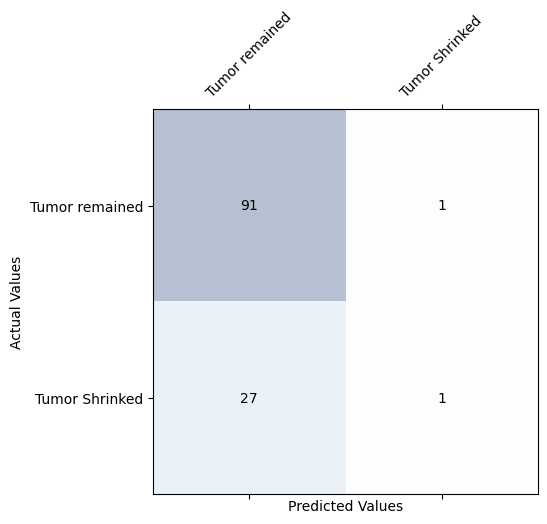

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

# {'svc__C': 7, 'svc__degree': 3, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}
svc = SVC(random_state=42, C=7, degree=3, gamma='auto', kernel='poly')

svc.fit(X_train, y_train)
print(accuracy_score(y_train, svc.predict(X_train)))
y_pred = svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["Tumor remained","Tumor Shrinked"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

0.7653429602888087
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87        92
         1.0       0.00      0.00      0.00        28

    accuracy                           0.77       120
   macro avg       0.38      0.50      0.43       120
weighted avg       0.59      0.77      0.67       120



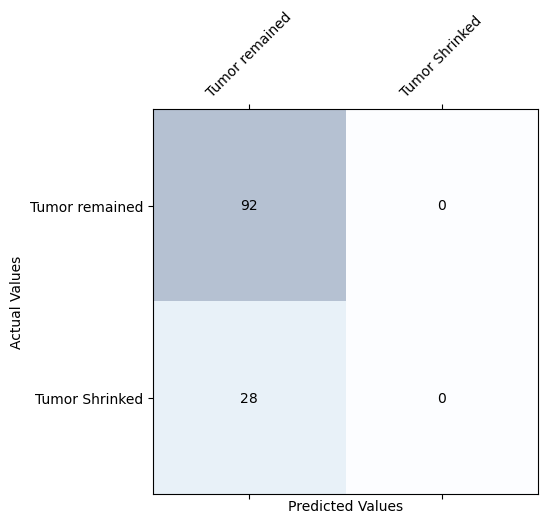

In [30]:
lr = LogisticRegression(random_state=42)

lr.fit(X_train, y_train)
print(accuracy_score(y_train, lr.predict(X_train)))
y_pred =lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["Tumor remained","Tumor Shrinked"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

0.6859205776173285
              precision    recall  f1-score   support

         0.0       0.82      0.61      0.70        92
         1.0       0.31      0.57      0.40        28

    accuracy                           0.60       120
   macro avg       0.57      0.59      0.55       120
weighted avg       0.70      0.60      0.63       120



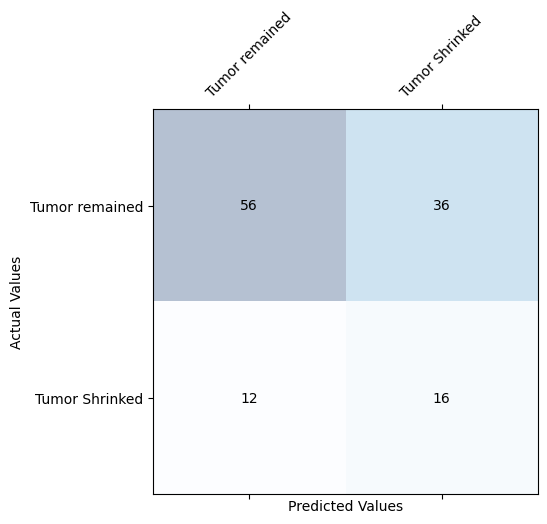

In [40]:
# RFC-FS: {'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 300}
# PI-FS: {'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 300}
# PI-FS (with train/test): (Train and test): {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 300}
# PI-FS (with train/test/upsampling): {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 200}
# {'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 300}
# {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 300}
# {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 400}
# {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 300}
# {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 95}
# {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 95}
# {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 80}
# {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 80}
# {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 50}
# {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 50}
rf= RandomForestClassifier(class_weight="balanced", random_state=42, criterion='gini', max_depth=3, max_features='auto', n_estimators=50)
rf.fit(X_train, y_train)
print(accuracy_score(y_train, rf.predict(X_train)))
y_pred =rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["Tumor remained","Tumor Shrinked"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

In [32]:
# test_df = pd.read_excel("./Dataset/testDatasetExample.xls", sheet_name="Sheet1")
# test_df = test_df[]

### K-Fold cross validation

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

models = []
models.append(("Random Forest", rf))

# Test options and evaluation metric
num_folds = 5
num_instances = len(X_train)
scoring = "accuracy"
results = []
names = []

for name, model in models:
    kf = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
print("5-Fold cross-validation accuracy score for the training data for all the classifiers")

for name, cv_results in zip(names, results):
    print("%-10s: %.6f (%.6f)" % (name, cv_results.mean(), cv_results.std()))

5-Fold cross-validation accuracy score for the training data for all the classifiers
Random Forest: 0.581299 (0.063696)


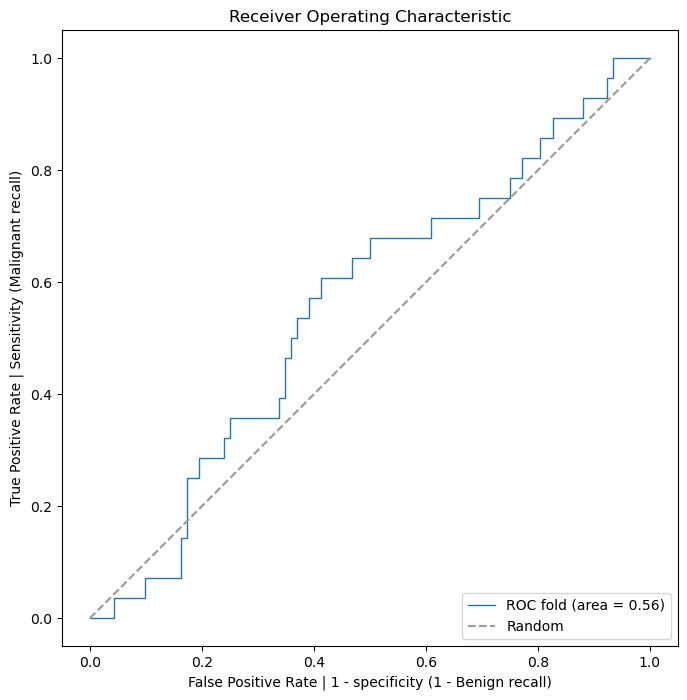

In [42]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10,8))
probas_ = rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC fold (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate | 1 - specificity (1 - Benign recall)')
plt.ylabel('True Positive Rate | Sensitivity (Malignant recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.axes().set_aspect(1);